In [685]:
# import libraries
import pandas as pd
import json
import re
import gdown
from datetime import datetime
from arango import ArangoClient
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from scipy import stats
from nltk import ngrams, FreqDist, word_tokenize

# import machine learning model and model dependency script
from model_dependency_script import text_preprocessing, sparse_to_dense
import joblib

**Introduction**

- In this notebook, we create a graph database('Goodreads_Book_Reviews') with Arango to store top_100 books and user_reviews of each book, as obtained from goodreads.com. The goodreads scraped data is stored in a google drive and as a result, will be uploaded from google drive to Arango.

    The aim of this exercise is to query data based on the relationship(s) that exists between data.

    In addition to this, analysis will be carried out to examine the relationship between Reviews and Rating. To aid this process, a machine learning spam filter has been developed to assist in the identification and filtering of spam or irrelevant reviews, whose presence in the dataset may affect the result of our analysis. For this task, spam/irrelevant reviews will be removed from the Book_Reviews collection and stored in a collection called 'Spam_Reviews'.
    
    Due to the size of the dataset, the books on which we would focus on from our database are: 
    1. To Kill a Mockingbird
    2. 1984
    3. The Lord of the Rings

link to spam_detector ML development and analysis: https://github.com/MartinFBanghart/Goodreads-Review-Webscraping-and-Text-Analysis/tree/main/Spam-Detection-ML

**Note**
- The **model_dependency_script.py** and **spam_detector.joblib** should be downloaded and situated in the same directory on your local machine for successful import.

## Connect to database

In [434]:
# Arango Client Connection
client = ArangoClient(hosts= "http://localhost:8529")

# database connection
db = client.db('Goodreads_Book_Reviews', username = 'root', password = 'bolajimartinArango')

## Check and Delete collections in the database if collections exist

In [151]:
list_of_collections = ['Top_100_Books', 'Book_Reviews', 'reviews_per_book', 'Spam_Reviews', 'spam_reviews_per_book']

for i in list_of_collections:
    if db.has_collection(i) == True:
        print('deleted status: {}'.format(db.delete_collection(i)))

deleted status: True
deleted status: True
deleted status: True
deleted status: True
deleted status: True


## Creating First Collection - Top_100_Books

Process:
- Read File from Google Drive and Change to JSON if file type is not Json
- Obtain Keys in the File
- Create collection (Top_100_Books)in the Goodreads_Book_Reviews Database
- Define the Schemas for the keys in the document and load document into the collection - Top_100_Books

In [152]:
# read file to be loaded into Arango from google drive into Python
url = "https://drive.google.com/file/d/1FuHlnpkGxleewKeCesZMAQYmhs-lB_Jb/view?usp=share_link"
file_path = "https://drive.google.com/uc?id=" + url.split('/')[-2]
top100books = pd.read_csv(file_path)

### data cleaning and transformation

In [153]:
# view data in csv
top100books.sample(2)

,Book Title,Book Link,Review Page Link,Unique ID
62,Go Tell It on the Mountain,https://www.goodreads.com/book/show/17143.Go_T...,https://www.goodreads.com/book/show/17143/revi...,17143
39,The Heart Is a Lonely Hunter,https://www.goodreads.com/book/show/37380.The_...,https://www.goodreads.com/book/show/37380/revi...,37380


In [154]:
# obtain the keys in the json file
columns_top100books = [i.lower().replace(' ', '_') for i in list(top100books.keys())]

for i in range(len(columns_top100books)):
    top100books = top100books.rename(columns = {top100books.columns[i]: columns_top100books[i]})

top100books.columns

Index(['book_title', 'book_link', 'review_page_link', 'unique_id'], dtype='object')

In [155]:
# transform into json format to load into Arango
top_100books_json = json.loads(top100books.to_json(orient='records'))

### data loading

In [156]:
# define schemas for the keys in the json file
top100books_schema = {
    'rule': {
        'type': 'object',
        'properties': {
            'book_title': {'type': ['string', 'null']},
            'book_link': {'type': ['string', 'null']},
            'review_page_link': {'type': ['string', 'null']},
            'unique_id' : {'type': ['integer', 'null']}
            
        },
        'required': ['book_title', 'book_link', 'review_page_link', 'unique_id']
    },
    'level': 'moderate',
    'message': 'Schema Validation Failed.'
}

# create collection in the database
top_100books_collection = db.create_collection('Top_100_Books', schema = top100books_schema)

# import json file into collection - top_100books_collection
top_100books_collection.import_bulk(top_100books_json)

{'error': False,
 'created': 100,
 'errors': 0,
 'empty': 0,
 'updated': 0,
 'ignored': 0,
 'details': []}

## Create Second Collection - Book Reviews

- Read File from Google Drive and Change to JSON if file type is not Json
- Obtain Keys in the File
- Create collection (Book_Reviews)in the Goodreads_Book_Reviews Database
- Define the Schemas for the keys in the document and load document into the collection - Book_Reviews

In [157]:
url_bookreviews = "https://drive.google.com/file/d/1SCrhzFD_pouvKb1njckacKsBWdSPMPjB/view?usp=share_link"
fileurl_bookreviews = "https://drive.google.com/uc?id=" + url_bookreviews.split('/')[-2]

# download file from google drive for easy loading into Python due to large file size preventing google drive from scanning
bookReviews = gdown.download(fileurl_bookreviews, 'BookReviews.csv', quiet=True)

# load downloaded data into pandas
book_reviews = pd.read_csv(bookReviews)

### data cleaning and transformation

In [158]:
book_reviews.head(2)

,User Href,Title,Rating,Date,Likes,Comments,Review,Display Name,User ID,Language
0,https://www.goodreads.com/user/show/45198798-l...,To Kill a Mockingbird,0.2,03-24-2022,964,88,/// gentle reminder that this is not the time ...,leynes,45198798,en
1,https://www.goodreads.com/user/show/1413439-st...,To Kill a Mockingbird,1.0,05-24-2011,1445,104,6.0 stars. I know I am risking a serious “FILM...,stephen,1413439,en


In [159]:
columns_book_reviews = [i.lower().replace(' ', '_') for i in list(book_reviews.keys())]

for i in range(len(columns_book_reviews)):
    book_reviews = book_reviews.rename(columns = {book_reviews.columns[i]: columns_book_reviews[i]})

book_reviews.columns

Index(['user_href', 'title', 'rating', 'date', 'likes', 'comments', 'review',
       'display_name', 'user_id', 'language'],
      dtype='object')

In [160]:
def datacleaning(dataframe):
    # multiply ratings by 5 to get the actual ratings
    dataframe['rating'] = dataframe['rating'].apply(lambda x: int(x * 5))
    
    return dataframe

# update dataframe
book_reviews = datacleaning(book_reviews)

# transform to json
book_reviews_json = json.loads(book_reviews.to_json(orient = 'records'))

### data loading

In [161]:
# define schemas for the keys in the json file
book_reviews_schema = {
    'rule': {
        'type': 'object',
        'properties': {
            'user_href': {'type': ['string', 'null']},
            'title': {'type': ['string', 'null']},
            'rating': {'type': ['integer', 'null']},
            'date' : {'type': ['string', 'null']},
            'likes' : {'type': ['integer', 'null']},
            'comments' : {'type': ['integer', 'null']},
            'review' : {'type': ['string', 'null']},
            'display_name': {'type': ['string', 'null']},
            'user_id' : {'type': ['integer', 'null']},
            'language' : {'type': ['string', 'null']}  
        },
        'required': ['user_href', 'title', 'rating', 'date', 'likes', 'comments', 'review', 'display_name', 'user_id', 'language']
    },
    'level': 'moderate',
    'message': 'Schema Validation Failed.'
}

# create collection in the database
book_reviews_collection = db.create_collection('Book_Reviews', schema = book_reviews_schema)

# import json file into collection - Book_Reviews
book_reviews_collection.import_bulk(book_reviews_json)

{'error': False,
 'created': 100359,
 'errors': 0,
 'empty': 0,
 'updated': 0,
 'ignored': 0,
 'details': []}

## Create Edge Collection Between Top 100 Books and Book Reviews

query for insertion in to edge document:
- for each book in the top_100_books collection, filter its reviews in the Book_Reviews collection by matching the book_title field in Top_100_Books to the title field in the Book_Reviews collection. Afterwhich define the connecting edges between both collections using the '._id' field

In [185]:
query = '''
FOR book IN Top_100_Books
    FOR reviews IN Book_Reviews
        FILTER reviews.title == book.book_title
        INSERT {
            _from: book._id,
            _to: reviews._id,
            user_id: reviews.user_id,
            display_name: reviews.display_name,
            title: reviews.title,
            rating: reviews.rating,
            review: reviews.review
        } INTO reviews_per_book
'''

# create edge collection
db.create_collection('reviews_per_book', edge=True)
cursor = db.aql.execute(query)

## Analysis

1. Process
    - Identify and Remove Irrelevant Reviews
    - Create Collection of Spam/Irrelevant Reviews and Remove from overall list of Book_Reviews
    - Perform Exploratory Analysis on Book_Reviews Collection
 
2. For this task, 3 books will be focused on due to the following:
    - Computation time
     - Difference in Nature of Reviews
     
3. Review Concentrations:
    - To Kill a Mockingbird
    - 1984
    - The Lord of the Rings

In [164]:
# retrieve documents for the the book concentrations listed above

query = '''
FOR book IN Book_Reviews
FILTER book.title IN ["To Kill a Mockingbird", "1984", "The Lord of the Rings"]
RETURN book
'''

dataset = pd.DataFrame(list(db.aql.execute(query)))
dataset.sample(3)

,_key,_id,_rev,user_href,title,rating,date,likes,comments,review,display_name,user_id,language
32,1703155,Book_Reviews/1703155,_f3shdCW---,https://www.goodreads.com/user/show/4685500-an...,To Kill a Mockingbird,5,09-1-2017,180,49,"The first time I read this I was much , much y...",angela-m,4685500,en
1817,1716562,Book_Reviews/1716562,_f3shdpK--d,https://www.goodreads.com/user/show/5159766-l-...,1984,5,03-23-2021,20,0,"This is the book to read right now, even if yo...",l-a-starks,5159766,en
2704,1728230,Book_Reviews/1728230,_f3shd8i--b,https://www.goodreads.com/user/show/6519317-mia,The Lord of the Rings,4,10-16-2014,3,0,The Lord of the Rings: My EverestIt took over ...,mia,6519317,en


### Identify Irrelevant/Spam Reviews using ML Model - Please see link in Introduction Cell on How to Import and Use

In [165]:
# import spam detector
model_path = '/Users/mobolajishobanke/Desktop/Personal/Personal Projects/Machine Learning/spam_detector.joblib'
spam_detector = joblib.load(model_path)

# view spam_detector_pipeline model
print('Model Pipeline: {}\n'.format(spam_detector))

# identify relevant and irrelevant reviews 
label = spam_detector.predict(dataset.review)

# print results
print('Number of Relevant and Irrelevant Reviews:\n{}'.format(pd.DataFrame(label).value_counts()))

Model Pipeline: Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function text_preprocessing at 0x7fdb4cf77820>)),
                ('tfidfvectorizer', TfidfVectorizer()),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function sparse_to_dense at 0x7fdb4cfae430>)),
                ('pca', PCA(n_components=59)),
                ('svc',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

Number of Relevant and Irrelevant Reviews:
0    3173
1     134
dtype: int64


## Create Spam Reviews Collection

In [170]:
# collect spam reviews into a separate collection
dataset['spam'] = label
spam_reviews_json = json.loads(dataset[dataset.spam == 1].to_json(orient = 'records'))

# create spam_reviews collection in arango
spam_reviews_collection = db.create_collection('Spam_Reviews', schema = book_reviews_schema)

# import json file into collection - Book_Reviews
spam_reviews_collection.import_bulk(spam_reviews_json)

{'error': False,
 'created': 134,
 'errors': 0,
 'empty': 0,
 'updated': 0,
 'ignored': 0,
 'details': []}

### Remove Duplicate reviews that exist in Book_Reviews and Spam_Reviews

In [194]:
query = '''
FOR reviews IN Book_Reviews
FILTER reviews._key IN (FOR spam IN Spam_Reviews RETURN spam._key)
REMOVE reviews IN Book_Reviews
'''

db.aql.execute(query)

#check
collections = ['Spam_Reviews', 'Book_Reviews']
reference_document = spam_reviews_json[0]['_key']

print(f'Check: \nIf successfully removed, reference_document ({reference_document}) should exist in Spam_Reviews but not in Book_Reviews\n')

for i in collections:
    q = f''' FOR rev IN {i}
    FILTER rev._key == '{reference_document}'
    RETURN rev'''
    
    check = list(db.aql.execute(q))

    if len(check) == 0:
        print(f"Document Not Found in >> {i}")
    else:
        print(f"Document Found in >> {i} ")

Check: 
If successfully removed, reference_document (1703141) should exist in Spam_Reviews but not in Book_Reviews

Document Found in >> Spam_Reviews 
Document Not Found in >> Book_Reviews


### Create Edge Collection between Spam_Reviews and Book_Reviews

In [196]:
query = '''
FOR reviewer IN Book_Reviews
    FOR review IN Spam_Reviews
        FILTER reviewer.user_id == review.user_id
        INSERT {
            _from: reviewer._id,
            _to: review._id,
        } INTO spam_reviews_per_book
'''

# create edge collection
db.create_collection('spam_reviews_per_book', edge=True)
cursor = db.aql.execute(query)

### Loading Flagged Spammers Reviews Collections

In [ ]:
## Querying to get Spammers IDs in a list
query = '''
    FOR doc IN Spam_Reviews
    RETURN {'user_id' : doc.user_id, 'display_name' : doc.display_name }
'''

cursor = db.aql.execute(query)
results = list(cursor)

df = pd.DataFrame(results)

In [ ]:
url_spammerreviews = "https://drive.google.com/file/d/1AlGydm7_jOcDePZUhM1iiP2aDND_45Kn/view?usp=share_link"
fileurl_spammerreviews = "https://drive.google.com/uc?id="+ url_spammerreviews.split('/')[-2]

# download file from google drive for easy loading into Python due to large file size preventing google drive from scanning
spammerreviews = gdown.download(fileurl_spammerreviews, 'spammer_reviews_cdone.csv', quiet=True)

# load downloaded data into pandas
spammer_reviews = pd.read_csv(spammerreviews).drop('Unnamed: 0', axis=1)

In [ ]:
# transform to json
spammer_reviews_json = json.loads(spammer_reviews.to_json(orient = 'records'))

In [ ]:
# define schemas for the keys in the json file
spammer_reviews_schema = {
    'rule': {
        'type': 'object',
        'properties': {
            'user_id': {'type': ['integer', 'null']},
            'review_id': {'type': ['integer', 'null']},
            'title': {'type': ['string', 'null']},
            'author': {'type': ['string', 'null']},
            'rating': {'type': ['number', 'null']},
            'review' : {'type': ['string', 'null']},
            'date_added': {'type': ['string', 'null']},
            'lang' : {'type': ['string', 'null']},
            'spam' : {'type': ['string', 'null']}  
        },
        'required': ['user_id', 'review_id', 'title', 'author', 'rating', 'review', 'date_added', 'lang', 'spam']
    },
    'level': 'moderate',
    'message': 'Schema Validation Failed.'
}

# create collection in the database
spammer_reviews_collection = db.create_collection('flagged_for_spam_reviews', schema = spammer_reviews_schema)

# import json file into collection - Book_Reviews
spammer_reviews_collection.import_bulk(spammer_reviews_json)

## Exploratory Analysis using Arango Query Language

In [559]:
query ='''
FOR books IN Book_Reviews
    FILTER books.title IN ["To Kill a Mockingbird", "1984", "The Lord of the Rings"]
    COLLECT Rating = books.rating AGGREGATE num_reviews =  COUNT(books.likes),
                avg_char_len = AVERAGE(CHAR_LENGTH(books.review)),
                max_char_len = MAX(CHAR_LENGTH(books.review)),
                min_char_len = MIN(CHAR_LENGTH(books.review)),
                tot_likes = SUM(books.likes),
                tot_comments = SUM(books.comments)

        
    RETURN {rating: Rating, 
            review_count: num_reviews,
            avg_character_len: ROUND(avg_char_len),
            min_character_len: min_char_len,
            max_character_len: max_char_len,
            total_likes: tot_likes,
            total_comments: tot_comments
            }
'''
summary_stat = pd.DataFrame(list(db.aql.execute(query)))
summary_stat

,rating,review_count,avg_character_len,min_character_len,max_character_len,total_likes,total_comments
0,0,59,970,3,7025,1536,211
1,1,69,1019,4,8139,3530,721
2,2,85,1279,16,8547,4328,726
3,3,188,1612,24,13192,5333,878
4,4,765,1386,4,19090,21374,2392
5,5,2007,1428,4,19672,68676,7777


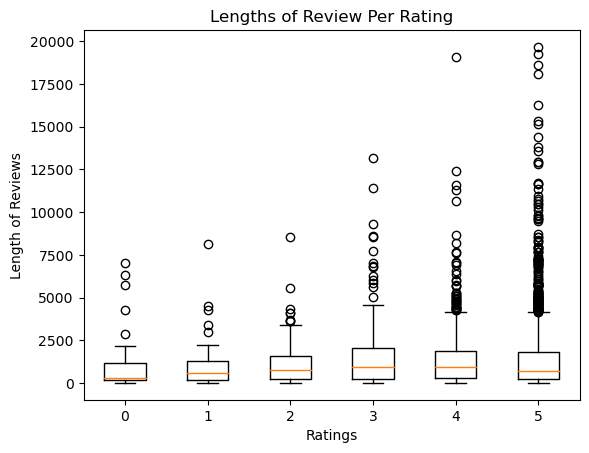

In [523]:
ratings = [0, 1, 2, 3, 4, 5]
reviews_char_length = []

for i in ratings:
    query = f'''
    FOR books in Book_Reviews
        FILTER books.title IN ["To Kill a Mockingbird", "1984", "The Lord of the Rings"]
        FILTER books.rating == {i}
        RETURN CHAR_LENGTH(books.review)
        '''
    char_length = np.array(list(db.aql.execute(query))).T
    reviews_char_length.append(char_length)
    
# plot result
plt.boxplot(reviews_char_length)
plt.xticks(range(1, 7), ratings)
plt.xlabel('Ratings')
plt.ylabel('Length of Reviews')
plt.title('Lengths of Review Per Rating')
plt.show()

**Observation:**
- There seems to be a positive relationship between number of reviews and rating.That is, the higher the rating, the higher the number of reviews.
- There also is a positive relationship between averagelength of reviews(text) and reviewer's rating. This could imply that people who rate a book highly tend to be more expressive in their reviews, than those who rate a book poorly. However, the slight difference between the average length of reviews(text) is significantly small and could therefore mean that the variable avg_character_len is independent of rating 

### Check Distribution of length of reviews(text) in each rating

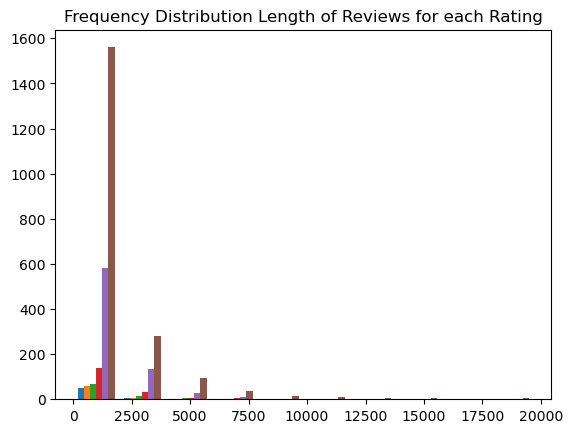

In [628]:
# check distribution of character lengths of in each rating 
plt.hist(reviews_char_length)
plt.title('Frequency Distribution Length of Reviews for each Rating')
plt.show()

### Check Correlation Between between Ratings and length of Reviews

In [682]:
query = '''
FOR books in Book_Reviews
    FILTER books.title IN ["To Kill a Mockingbird", "1984", "The Lord of the Rings"]
    RETURN [books.rating, CHAR_LENGTH(books.review), books.review]
        '''
ratings_reviews = pd.DataFrame(list(db.aql.execute(query)), columns = ['ratings', 'reviews_length', 'reviews'])
ratings_reviews.corr()

,ratings,reviews_length
ratings,1.000000,0.031256
reviews_length,0.031256,1.000000


### Carry Out Chi-Square test to evaluate if there is independence between the total_character_length of reviews and ratings

In [676]:
#check for dependency

chi_square, pvalue = chi2(ratings_reviews['ratings'].values.reshape(-1,1), ratings_reviews['reviews_length'].values.reshape(-1,1))
chi2_df = pd.DataFrame([chi_square, pvalues], index = ['chisquare', 'pvalue']).transpose()
chi2_df

,chisquare,pvalue
0,477.251923,1.0


**Observation**
- P-value derived from Chisquare_test is > 0.05. Therefore, we fail to reject the null hypothesis there is no association or relationship between length_of_reviews and rating. 

- Correlation coefficient betweeen length of reviews and ratings is 0.03, which is also indicative that there is no relationship between the 2 variables being compared

 - **Length of reviews has no impact on reviewer's rating**

## See Most Frequent Occuring Words in Top Ratings using Bigram

In [708]:
def get_top_5_bigrams_from_reviews(reviews):
    # Create a list to store all bi-grams
    all_bi_grams = []
    
    for review in reviews:
        # Tokenize the sentence into words
        words = word_tokenize(review)

        # Create bi-grams from the words
        bi_grams = list(ngrams(words, 2))

        # Add the bi-grams to the list of all bi-grams
        all_bi_grams.extend(bi_grams)

    # Calculate the frequency distribution of bi-grams
    freq_dist = FreqDist(all_bi_grams)

    # Find the top 5 most common bi-grams
    top_5_bigrams = freq_dist.most_common(5)

    # Return the top 5 most common bi-grams
    return top_5_bigrams

In [ ]:
reviews_5 = text_preprocessing(ratings_reviews[ratings_reviews.ratings == 5].reviews)
top_5_bigrams = pd.DataFrame(get_top_5_bigrams_from_reviews(reviews_5), columns=['bigrams', 'Frequency'])
top_5_bigrams

,bigrams,Frequency
0,"(lord, ring)",493
1,"(read, book)",434
2,"(big, brother)",400
3,"(kill, mockingbird)",349
4,"(harper, lee)",285


**Conclusion**

The top 5 bigrams associated with 5-star ratings consist of commonly used words that are linked to the content, characters, or authors of the books in this category. This suggests that the rating is more closely tied to the specific words used in the reviews rather than the length of the reviews themselves.

Bayesian Statistics could be adopted to examine this relationship.